<a href="https://colab.research.google.com/github/d4k5h-BITSPILANI/sentiment-Analysis/blob/main/examples/tutorial_5_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
pip install snntorch torch torchvision matplotlib


In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
])

# Download and load the training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate

# Define the network architecture
class CSNN(nn.Module):
    def __init__(self):
        super(CSNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 5)  # 1 input channel, 12 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(12, 64, 5) # 12 input channels, 64 output channels, 5x5 kernel
        self.fc1 = nn.Linear(64 * 4 * 4, 10)  # Fully connected layer
        self.lif1 = snn.Leaky(beta=0.5, spike_grad=surrogate.fast_sigmoid())
        self.lif2 = snn.Leaky(beta=0.5, spike_grad=surrogate.fast_sigmoid())
        self.lif3 = snn.Leaky(beta=0.5, spike_grad=surrogate.fast_sigmoid(), output=True)

    def forward(self, x):
        # Initialize hidden states
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Layer 1: Convolution + LIF
        cur1 = self.conv1(x)
        spk1, mem1 = self.lif1(cur1, mem1)
        spk1 = nn.MaxPool2d(2)(spk1)

        # Layer 2: Convolution + LIF
        cur2 = self.conv2(spk1)
        spk2, mem2 = self.lif2(cur2, mem2)
        spk2 = nn.MaxPool2d(2)(spk2)

        # Flatten and Fully Connected Layer + LIF
        spk2 = spk2.view(spk2.size(0), -1)
        cur3 = self.fc1(spk2)
        spk3, mem3 = self.lif3(cur3, mem3)

        return spk3, mem3

# Instantiate the model and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSNN().to(device)


In [5]:
import torch.optim as optim
import snntorch.functional as SF
import snntorch.utils as utils
# Define loss function and optimizer
loss_fn = SF.ce_rate_loss()
optimizer = optim.Adam(model.parameters(), lr=2e-3)

# Training parameters
num_epochs = 5
num_steps = 50  # Number of time steps to run the simulation

# Training loop
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Initialize hidden states
        spk_rec = []
        mem_rec = []
        utils.reset(model)  # Reset hidden states for all LIF neurons in the network

        # Forward pass over multiple time steps
        for step in range(num_steps):
            spk_out, mem_out = model(images)
            spk_rec.append(spk_out)
            mem_rec.append(mem_out)

        # Stack the recorded spikes
        spk_rec = torch.stack(spk_rec)

        # Compute loss
        loss = loss_fn(spk_rec, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 1/5, Loss: 2.3026
Epoch 2/5, Loss: 1.6121
Epoch 3/5, Loss: 1.4830
Epoch 4/5, Loss: 1.5397
Epoch 5/5, Loss: 1.5068


uptill here, it was csnn, now doing the basic stuff


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import snntorch as snn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


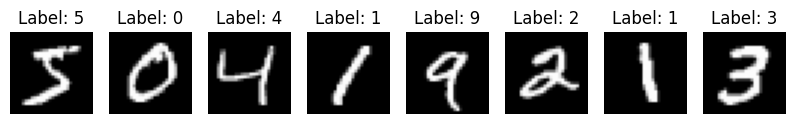

In [12]:
# Transform: Convert images to tensors and normalize them
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])

# Load MNIST dataset
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create DataLoader
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualize some images
fig, axes = plt.subplots(1, 8, figsize=(10, 2))
for i in range(8):
    image, label = train_dataset[i]
    axes[i].imshow(image.squeeze(), cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")
plt.show()


In [13]:
class BasicSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 200)  # Fully connected layer (784 → 200 neurons)
        self.lif1 = snn.Leaky(beta=0.9)  # Leaky Integrate-and-Fire neuron
        self.fc2 = nn.Linear(200, 10)  # Fully connected layer (200 → 10 neurons)
        self.lif2 = snn.Leaky(beta=0.9)  # Output layer with LIF neurons

    def forward(self, x):
        mem1 = self.lif1.init_leaky()  # Initialize membrane potential
        mem2 = self.lif2.init_leaky()

        spk1, mem1 = self.lif1(self.fc1(x.view(x.shape[0], -1)), mem1)  # First Layer
        spk2, mem2 = self.lif2(self.fc2(spk1), mem2)  # Output Layer

        return spk2, mem2


Epoch 1/5, Loss: 1.5782
Epoch 2/5, Loss: 1.5127
Epoch 3/5, Loss: 1.5022
Epoch 4/5, Loss: 1.4964
Epoch 5/5, Loss: 1.4930


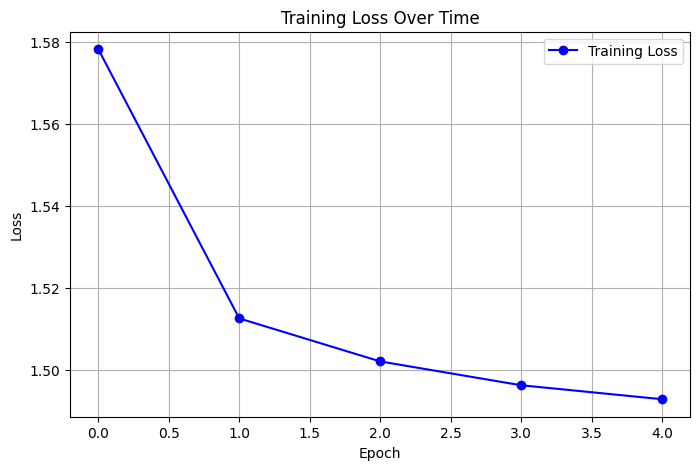

In [14]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
snn_model = BasicSNN().to(device)

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(snn_model.parameters(), lr=1e-3)

# Training loop
num_epochs = 5
loss_list = []  # Store loss for visualization

for epoch in range(num_epochs):
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        spk_out, _ = snn_model(images)  # Forward pass
        loss = loss_fn(spk_out, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_list.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Plot the Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(loss_list, marker="o", linestyle="-", color="b", label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid()
plt.show()


Test Accuracy: 92.45%


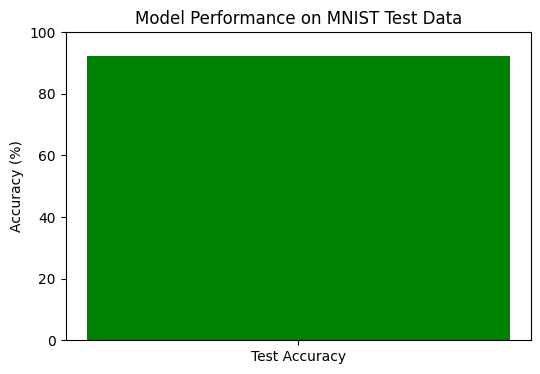

In [15]:
def test_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            spk_out, _ = model(images)  # Forward pass
            _, predicted = torch.max(spk_out, 1)  # Get class with highest probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Evaluate the trained model
accuracy = test_model(snn_model, test_loader)

# Plot Accuracy
plt.figure(figsize=(6, 4))
plt.bar(["Test Accuracy"], [accuracy], color="green")
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("Model Performance on MNIST Test Data")
plt.show()


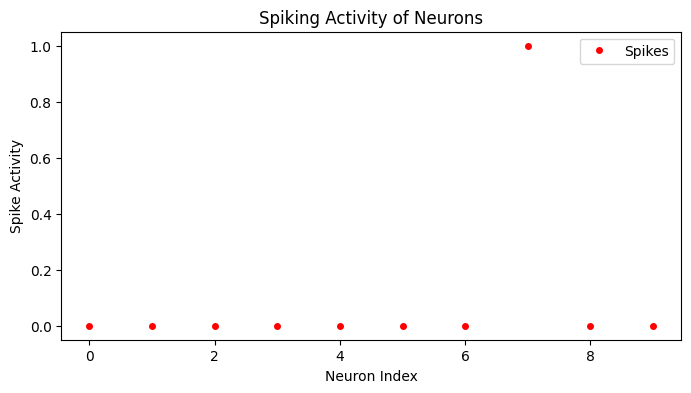

In [16]:
# Visualize spike activity for a sample image
sample_image, _ = test_dataset[0]
sample_image = sample_image.to(device).view(1, -1)

# Forward pass through the network
spk_out, _ = snn_model(sample_image)

# Convert spike output to NumPy for visualization
spk_np = spk_out.cpu().detach().numpy().flatten()

# Plot spike activity
plt.figure(figsize=(8, 4))
plt.plot(spk_np, "ro", markersize=4, label="Spikes")
plt.xlabel("Neuron Index")
plt.ylabel("Spike Activity")
plt.title("Spiking Activity of Neurons")
plt.legend()
plt.show()
